In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

C:\Users\xia\AppData\Local\Temp\ipykernel_7760\3802281906.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\xia\AppData\Local\Temp\ipykernel_7760\3802281906.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


In [6]:
def getData(filename1,filename2, remove_duplicata = True):
    df1 = pd.read_csv(filename1)
    df1.drop(df1.columns[len(df1.columns)-1], axis=1,inplace = True)
    df2 = pd.read_csv(filename2)
    X1 = df1.to_numpy()
    X2 = df2.to_numpy()
    s1, s2 = X1.shape[1], X2.shape[1]
    X11, X12 = X1[:,s1//2:], X1[:,:s1//2]
    X21, X22 = X2[:,s1//2:], X2[:,:s1//2]
    X = np.hstack((X11,X21,X12,X22))
    return X[:,:-1], X[:,-1]

In [7]:
def extractdata(filename, remove_duplicata = True):
    with open(filename) as f:
        df = pd.read_csv(f)
        if remove_duplicata:
            df = df.drop_duplicates()
        X = df.to_numpy()
    return X[:,:-1], X[:,-1]


In [8]:
X,Y = extractdata("dataBow.csv")
X=X.astype("int64")
X=np.unique(X,axis=0,return_index=True)
X,index = X
Y = Y[index]

In [9]:
print(Y)

['WriteWord' 'WriteWord' 'WriteWord' ... 'copyPaste' 'replace' 'replace']


In [10]:
X.shape

(72854, 5762)

In [11]:

le = preprocessing.LabelEncoder()
newX = normalize(X)

tmp = X[:,X.shape[1]//2:]
anotherX = X[:,:X.shape[1]//2]-tmp
print(anotherX.shape)
anotherX = normalize(anotherX)
le.fit(Y)
Ynum = le.transform(Y)

(72854, 2881)


In [12]:
le.classes_

array(['WriteWord', 'copyPaste', 'deleteWord', 'replace'], dtype=object)

In [13]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(anotherX),torch.Tensor(Ynum).type(torch.LongTensor))

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [15]:
np.unique(Ynum, return_counts=True)

(array([0, 1, 2, 3]), array([44054,  9720,  9077, 10003], dtype=int64))

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2881, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        # For BCELoss
        #y = y.unsqueeze(1)
        #y = y.float()
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [18]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            # For BCELoss
            #y = y.unsqueeze(1)
            #y = y.float()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # BCELoss
            #pred = (pred > 0.5).long()
            #correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
epochs = 20

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


# Create the data loaders for training and validation
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=2000,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=2000,
    shuffle=False
)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.382570  [ 2000/58283]
Test Error: 
 Accuracy: 72.9%, Avg loss: 0.898151 

Epoch 2
-------------------------------
loss: 0.852069  [ 2000/58283]
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.614323 

Epoch 3
-------------------------------
loss: 0.632484  [ 2000/58283]
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.498434 

Epoch 4
-------------------------------
loss: 0.474506  [ 2000/58283]
Test Error: 
 Accuracy: 91.2%, Avg loss: 0.249102 

Epoch 5
-------------------------------
loss: 0.214423  [ 2000/58283]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.150456 

Epoch 6
-------------------------------
loss: 0.112512  [ 2000/58283]
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.121275 

Epoch 7
-------------------------------
loss: 0.099945  [ 2000/58283]
Test Error: 
 Accuracy: 96.6%, Avg loss: 0.103496 

Epoch 8
-------------------------------
loss: 0.070569  [ 2000/58283]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.082189 

Epoch 9
----------------

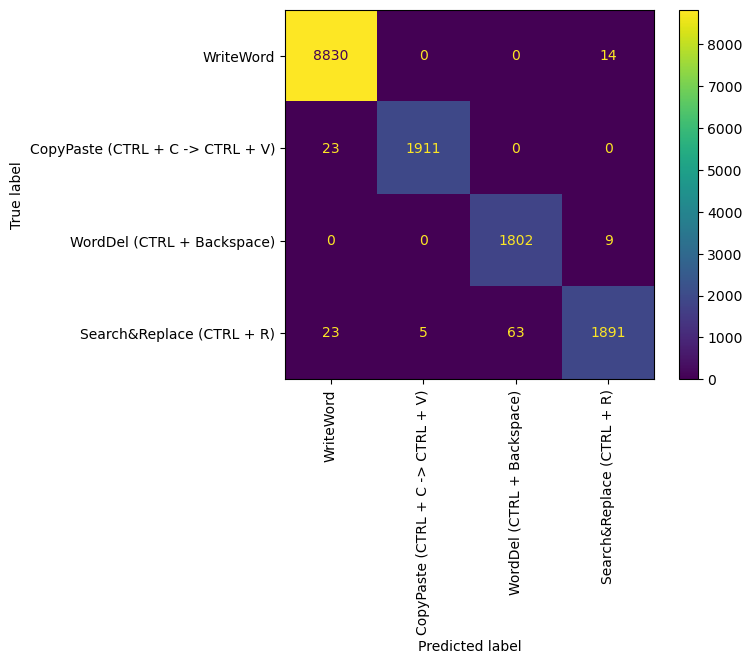

In [24]:
#
commandes = ["WriteWord","CopyPaste (CTRL + C -> CTRL + V)","WordDel (CTRL + Backspace)","Search&Replace (CTRL + R)"]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Used to calculate the confusion matrix
y_true = []
y_pred = []
predictions = []
for X,y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())

    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    predictions.extend(pred.tolist())
    y_pred.extend(pred.argmax(1).data.cpu().numpy())
    
    #pred = (pred > 0.5).long()
    #y_pred.extend(pred.data.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=commandes)
disp.plot()
plt.xticks(rotation=90)
plt.show()

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)


In [22]:
prec = np.round(precision_score(y_true, y_pred, average=None), 3)
rap = np.round(recall_score(y_true, y_pred, average=None), 3)
FPR = FP/(FP+TN)
print("Precision :",dict(zip(le.classes_, prec)))
print("\n")
print("Rappel :", dict(zip(le.classes_, rap)))
print("\n")
#print("FPR : ",dict(zip(le.classes_, FP/conf_matrix.sum(axis=0))))
print("FPR : ",dict(zip(le.classes_, FPR)))
print("\n")
print("ROC AUC SCORE :",roc_auc_score(y_true, predictions, multi_class='ovr'))

Precision : {'WriteWord': 0.995, 'copyPaste': 0.997, 'deleteWord': 0.966, 'replace': 0.988}


Rappel : {'WriteWord': 0.998, 'copyPaste': 0.988, 'deleteWord': 0.995, 'replace': 0.954}


FPR :  {'WriteWord': 0.008032128514056224, 'copyPaste': 0.0003956635277360133, 'deleteWord': 0.00493730407523511, 'replace': 0.0018269918182540314}


ROC AUC SCORE : 0.9985475235409128


In [44]:
f1_score(y_true, y_pred, average=None)

array([0.99813612, 0.99611902, 0.97960294, 0.97406932])

Accuracy avant:  0.9927252762336147
Accuracy après:  0.9968465311843028
pred restantes:  14270
pred supprimees:  301
pourcentage restant:  0.9793425296822456


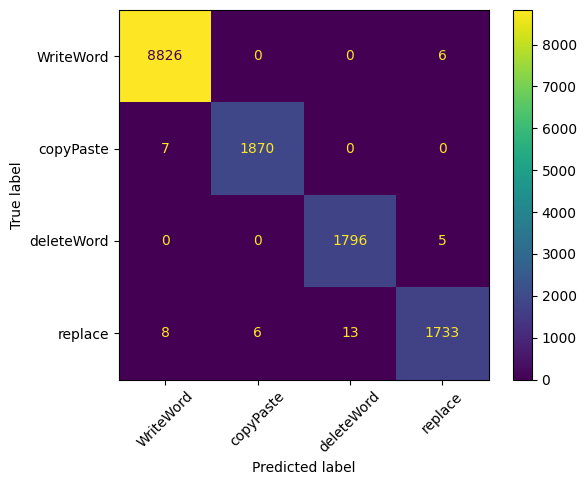

In [55]:

#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.95
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = np.unique(Y))
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))
plt.xticks(rotation=45)

plt.show()

In [45]:
torch.save(model.state_dict(), "./models/bowModelGood")

In [48]:
datatest,labtest = extractdata("dataBow.csv")
datatest=datatest.astype("int64")
datatest=np.unique(datatest,axis=0,return_index=True)
datatest,index = datatest
labtest = labtest[index]

In [49]:
le = preprocessing.LabelEncoder()
newdatatest = normalize(datatest)

tmp = datatest[:,datatest.shape[1]//2:]
anotherdatatest = datatest[:,:datatest.shape[1]//2]-tmp
anotherdatatest = normalize(anotherdatatest)
le.fit(labtest)
labtestnum = le.transform(labtest)

In [54]:
print(le.classes_)

['copyPaste' 'deleteWord' 'replace']


In [50]:
datatestset = torch.utils.data.TensorDataset(torch.Tensor(anotherdatatest),torch.Tensor(labtestnum).type(torch.LongTensor))

In [51]:
validation_dataloader = torch.utils.data.DataLoader(
    datatestset,
    shuffle=False
)

Accuracy avant:  0.20833333333333334
Accuracy après:  0.21739130434782608


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (3).

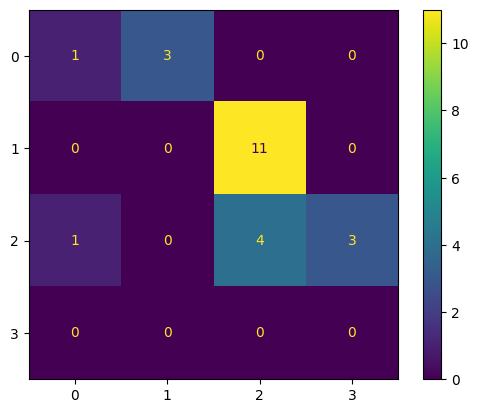

In [52]:

#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in validation_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.95
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = le.classes_)
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))
plt.xticks(rotation=45)

plt.show()